In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [3]:
rng = np.random.default_rng()
nside = 2**7
m = rng.standard_normal(size=(nside, nside)) #random values for pixelized map, m

In [4]:
P_lr = block_diag(np.eye(nside), np.flip(np.eye(nside), axis=1))

for i in range(6):
    P_lr = block_diag(P_lr, P_lr)

nsamp = P_lr.shape[0]

In [5]:
P_ud = np.zeros((nsamp, nsamp))

for i, row in enumerate(P_ud):
    chunk = i // nside
    index = i * nside - (chunk * nside**2) + chunk
    if chunk % 2:
        step_size = chunk*nside-(i-nside+1)
        index = nside * step_size + chunk
    row[index]=1

In [6]:
P = np.vstack([P_lr, P_ud])
nsamp = P.shape[0]

In [10]:
n = rng.standard_normal(nsamp)

x = np.linspace(0, 5 * np.pi, nsamp)
n_corr = 3 * np.sin(2*x)
n_corr = np.sqrt(2*x)

In [11]:
m = m.flatten()
y = P@m + n_corr # + n

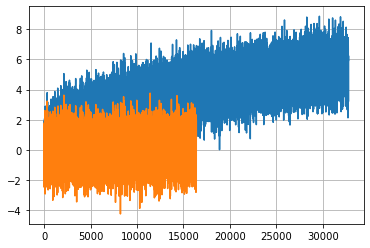

In [13]:
plt.plot(y)
plt.plot(m)
plt.grid()

In [14]:
#Baselines matrix F

n_baseline = 2**7

F = np.zeros((n_baseline, nsamp))

assert len(y) % n_baseline == 0

cutoff = len(y) // n_baseline
offset = 0 
for i in range(n_baseline):
    F[i][offset:offset+cutoff] = 1
    offset+=cutoff
    
F = F.T

In [15]:
# destriping
Z = np.eye(nsamp) - P @ np.linalg.inv(P.T @ P) @ P.T

#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ y

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

(128, 128) 127


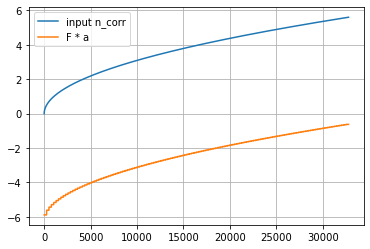

In [16]:
plt.plot(n_corr, label='input n_corr')
plt.plot(F @ a, label='F * a')
plt.grid()
plt.legend()

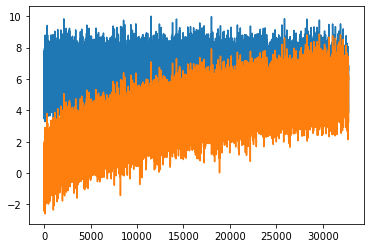

In [17]:
plt.plot(y-F@a)
plt.plot(y)

In [18]:
m_solver = np.linalg.inv(P.T @ P) @ P.T

m_destripe = m_solver @ (y - F @ a) #Destriping solution
m_bin = m_solver @ y #Binned map solution

#remove monopole
m_destripe -= np.mean(m_destripe)
m_bin -= np.mean(m_bin)

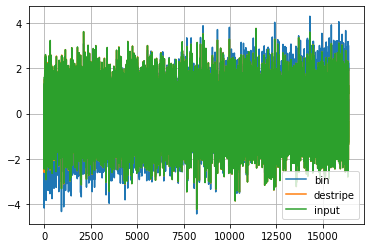

In [19]:
plt.plot(m_bin, label='bin')
plt.plot(m_destripe, label='destripe')
plt.plot(m, label='input')
plt.grid()
plt.legend()

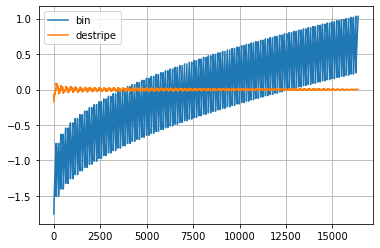

In [20]:
plt.plot(m_bin - m, label='bin')
plt.plot(m_destripe - m, label='destripe')
plt.grid()
plt.legend()